# Fine-Grained Classification Task Report

The Fine-grained classification task aims to distinguish subtle differences between classes, specifically in classifying airplane models. This report outlines the data pre-processing, model training and selection of hyper-parameters for this task.

The dataset for airplane model classification was obtained from Kaggle. The dataset includes training, validation, and test sets. The test set was reserved for evaluating the final model's performance.

For this project, I utilized Python libraries such as torch, torchvision, and pandas. The data preprocessing involved resizing images to 512x512 pixels and normalizing them using standard ImageNet mean and standard deviation values. A custom AircraftDataset class was implemented to handle the dataset. The model architecture was based on ResNet-50, a proven model in image classification tasks. Transfer learning was employed with weights pre-trained on ImageNet.

The chosen hyper-parameters were a batch size of 16, a learning rate of 0.0001, and training for ten epochs. These parameters were selected to balance the training speed and model accuracy. The learning rate was low to allow for fine-tuning on the pre-trained network without causing significant disruptions in the pre-learned weights.

During training, the model's accuracy on the test set was monitored and the best-performing model was saved. The final evaluation metrics included accuracy, precision, recall, and a confusion matrix.

The project demonstrated that careful selection of hyper-parameters and effective use of transfer learning could yield high accuracy in fine-grained image classification tasks.

#### Importing Essential Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Transfer Learning and Fine-Tuning with ResNet-50 for Aircraft Image Classification

#### Loading and Training the Model

In [ ]:
# Data directories and files
data_dir = '/content/drive/MyDrive/Task 2 DL/images'  # Directory containing aircraft images
train_file = '/content/drive/MyDrive/Task 2 DL/train.csv'  # CSV file containing training data (image file paths and labels)
test_file = '/content/drive/MyDrive/Task 2 DL/test.csv'  # CSV file containing test data (image file paths and labels)
saved_model_path = '/content/drive/MyDrive/Task 2 DL/res_50_bestmodel.pth'  # Specify where to save the trained model

# Hyperparameters
batch_size = 16
learning_rate = 0.0001
num_epochs = 10

# Read CSV files
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

# Define transforms for data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class AircraftDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.df.iloc[idx, 2], dtype=torch.long)

        return image, label

# Create datasets and data loaders
train_dataset = AircraftDataset(train_df, data_dir, transform=train_transform)
test_dataset = AircraftDataset(test_df, data_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, train_df['Labels'].nunique())

# Loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)

# Fine-tuning loop
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluate on test set
    true_labels = []
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)

    print(f"Accuracy on test set: {accuracy * 100:.2f}%")

    # Check if current model is better and save it
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), saved_model_path)
        print("Model saved")

    # Adjust learning rate based on validation accuracy
    scheduler.step(accuracy)

print(f"Best accuracy on test set: {best_accuracy * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


Epoch [1/10], Loss: 3.9446
Accuracy on test set: 26.04%
Model saved
Epoch [2/10], Loss: 2.3870
Accuracy on test set: 46.02%
Model saved
Epoch [3/10], Loss: 1.4186
Accuracy on test set: 54.07%
Model saved
Epoch [4/10], Loss: 0.8921
Accuracy on test set: 67.96%
Model saved
Epoch [5/10], Loss: 0.5364
Accuracy on test set: 69.01%
Model saved
Epoch [6/10], Loss: 0.3466
Accuracy on test set: 72.64%
Model saved
Epoch [7/10], Loss: 0.1910
Accuracy on test set: 73.39%
Model saved
Epoch [8/10], Loss: 0.1293
Accuracy on test set: 74.50%
Model saved
Epoch [9/10], Loss: 0.0882
Accuracy on test set: 77.26%
Model saved
Epoch [10/10], Loss: 0.0742
Accuracy on test set: 78.13%
Model saved
Best accuracy on test set: 78.13%


### Evaluation of Best Model and Metrics Calculation

In [ ]:
# Load the best model
best_model = models.resnet50(pretrained=False)
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, train_df['Labels'].nunique())
best_model.load_state_dict(torch.load(saved_model_path))

# Evaluate the best model on the test set
best_model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

# Calculate metrics using the predictions made by the best model
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy on test set: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)

Accuracy on test set: 78.13%
Precision: 80.26%
Recall: 78.13%
Confusion Matrix:
 [[31  0  0 ...  0  0  0]
 [ 0 29  1 ...  0  0  0]
 [ 0  0 22 ...  0  0  0]
 ...
 [ 1  0  0 ... 31  0  0]
 [ 1  0  0 ...  1 30  1]
 [ 0  0  0 ...  0  0 33]]


### Inference and Visualization with Trained Model

In [ ]:
train_file = '/content/drive/MyDrive/Task 2 DL/train.csv'
train_df = pd.read_csv(train_file)

Predicted class: 4, Probability: 0.9693


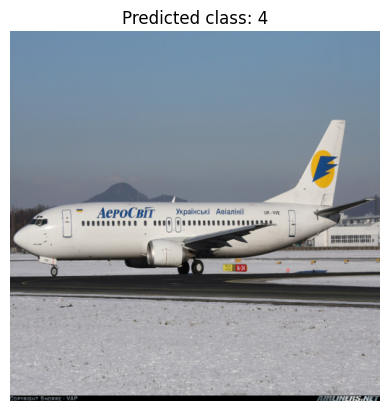

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_df['Labels'].unique()))
model.load_state_dict(torch.load('/content/drive/MyDrive/Task 2 DL/res_50_bestmodel.pth'))
model.eval()

# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the test image
image_path = '/content/drive/MyDrive/Task 2 DL/images/1334567.jpg'  # Path to the test image
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)

# Perform inference
with torch.no_grad():
    output = model(image_tensor)

# Convert the model output to probabilities and retrieve the predicted label
probabilities = torch.softmax(output, dim=1)[0]
predicted_class = torch.argmax(probabilities).item()

# Optionally, print the predicted class and its probability
print(f"Predicted class: {predicted_class}, Probability: {probabilities[predicted_class]:.4f}")

# Visualize the image with the predicted class
import matplotlib.pyplot as plt
import numpy as np

# Defining a function to reverse the normalization for visualization
def denormalize(image_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = np.transpose(image_tensor.numpy(), (1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

# Visualize the image with the predicted class
plt.imshow(denormalize(image_tensor.squeeze(0)))
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()